In [1]:
from keras import layers
from keras import models
import tensorflow as tf
from utils import constants
from utils import utils
from tensorflow.keras.applications.vgg16 import preprocess_input

2022-11-24 11:57:37.301176: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

In [3]:
#CONFIG
epochs = 20
batch_size = 8
learning_rate = 1e-5
input_shape = (224,224)
shape = (224,224,3)
layers_to_unfreeze = 8

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
input_shape = (224,224)

train_generator = train_datagen.flow_from_directory(
                    constants.TRAIN_DIRECTORY,
                    target_size=input_shape,
                    batch_size=8,
                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                        constants.VALIDATION_DIRECTORY,
                        target_size=input_shape,
                        batch_size=8,
                        class_mode='categorical')


Found 5934 images belonging to 4 classes.
Found 744 images belonging to 4 classes.


In [5]:
def build_model(num_classes):
    
    inputs = layers.Input(shape=shape)
    img_augmentation = models.Sequential(name="img_augmentation")
    x = img_augmentation(inputs)
    model = VGG16(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    
    # Compile
    model = tf.keras.Model(inputs, outputs, name="VGG16")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

    
def unfreeze_model(model, learning_rate):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layers_to_unfreeze:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            print(layer.name)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [6]:
model = build_model(4)
if layers_to_unfreeze > 0:
    unfreeze_model(model,learning_rate)
model.summary()

2022-11-24 11:57:47.525722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-24 11:57:47.587494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-24 11:57:47.588013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-24 11:57:47.588956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

block5_conv1
block5_conv2
block5_conv3
block5_pool
avg_pool
top_dropout
pred
Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  multiple                 0         
 l)                                                              
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)

In [7]:
hist = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/20


2022-11-24 11:57:56.210941: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-24 11:57:57.133518: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-24 11:57:57.638193: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-24 11:57:57.638257: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-24 11:57:57.868479: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

147/742 [====>.........................] - ETA: 1:37 - loss: 1.8742 - accuracy: 0.3486

2022-11-24 11:58:22.884361: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-24 11:58:22.884435: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


742/742 [==============================] - 146s 190ms/step - loss: 1.5005 - accuracy: 0.4513 - val_loss: 0.9937 - val_accuracy: 0.6532
Epoch 2/20
742/742 [==============================] - 143s 193ms/step - loss: 1.0987 - accuracy: 0.5982 - val_loss: 0.8538 - val_accuracy: 0.7083
Epoch 3/20
742/742 [==============================] - 143s 193ms/step - loss: 0.9339 - accuracy: 0.6493 - val_loss: 0.8185 - val_accuracy: 0.7151
Epoch 4/20
742/742 [==============================] - 142s 192ms/step - loss: 0.7956 - accuracy: 0.7058 - val_loss: 0.7155 - val_accuracy: 0.7567
Epoch 5/20
742/742 [==============================] - 150s 201ms/step - loss: 0.7241 - accuracy: 0.7268 - val_loss: 0.6879 - val_accuracy: 0.7473
Epoch 6/20
742/742 [==============================] - 145s 195ms/step - loss: 0.6775 - accuracy: 0.7514 - val_loss: 0.6707 - val_accuracy: 0.7769
Epoch 7/20
742/742 [==============================] - 152s 205ms/step - loss: 0.6198 - accuracy: 0.7705 - val_loss: 0.6364 - val_accura

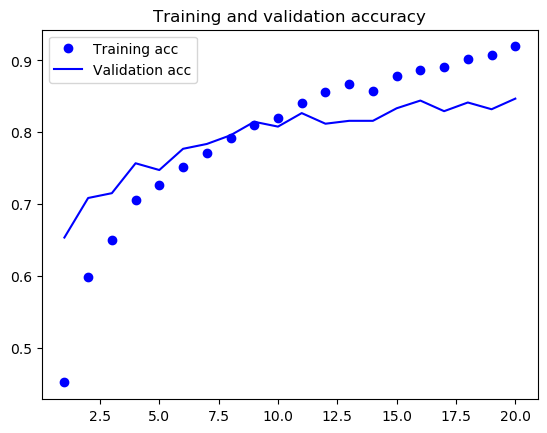

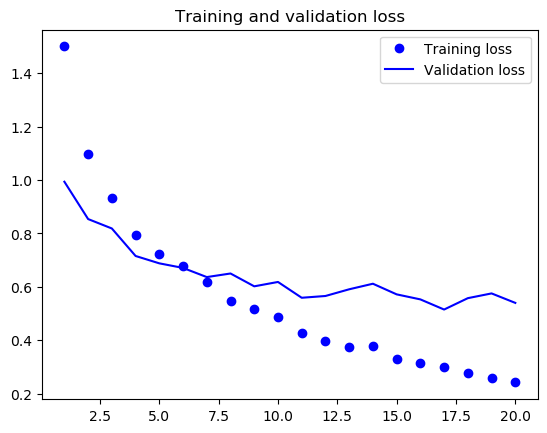

In [8]:
utils.plot_graphs(hist.history)

In [9]:
utils.show_stats([hist])

Max Accuracy:  0.9194472432136536  Mean Accuracy:  0.794076506793499  Max Val Accuracy:  0.8467742204666138  Mean Val Accuracy 0.792809134721756
Min Loss:  0.24144989252090454  Mean loss:  0.55975771099329 Min Val Loss:  0.514777660369873  Mean Val Loss:  0.6442138373851776


In [10]:
utils.save_dict_as_json(hist.history, "VGG16")

In [11]:
model.save('VGG16.h5')